In [1]:
import numpy as np
from math import floor
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
from imageio import imread
import matplotlib.cbook as cbook
from skimage import measure

import time

% matplotlib inline

Created TAP+ (v1.0) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [2]:
query=' '.join([
                'SELECT *',
               'FROM gaiadr2.gaia_source',
               'WHERE 1=CONTAINS(POINT(\'ICRS\', ra, dec),BOX(\'ICRS\', 149, 10, 16,16)) AND parallax >= 5'
                ])
               
               
llcc=Gaia.launch_job_async(query).get_results()

Launched query: 'SELECT * FROM gaiadr2.gaia_source WHERE 1=CONTAINS(POINT('ICRS', ra, dec),BOX('ICRS', 149, 10, 16,16))'
Retrieving async. results...


Query finished.


In [1]:
mag_thres=10 # Magnitude
dist_thres=50 # Parsecs
bright=llcc[llcc['phot_g_mean_mag']<mag_thres]
near=llcc[llcc['parallax']>1000./dist_thres]

bright.sort('parallax').reverse()
near.sort('parallax').reverse()

bright=bright[np.where(bright['parallax']!=np.ma.core.MaskedConstant)]
near=near[np.where(near['parallax']!=np.ma.core.MaskedConstant)]

NameError: name 'llcc' is not defined

/Users/codydirks/anaconda2/envs/astroconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '9:58:39.6595 +13:23:39.8446': No astronomical object found :
  (error.line, error.msg))


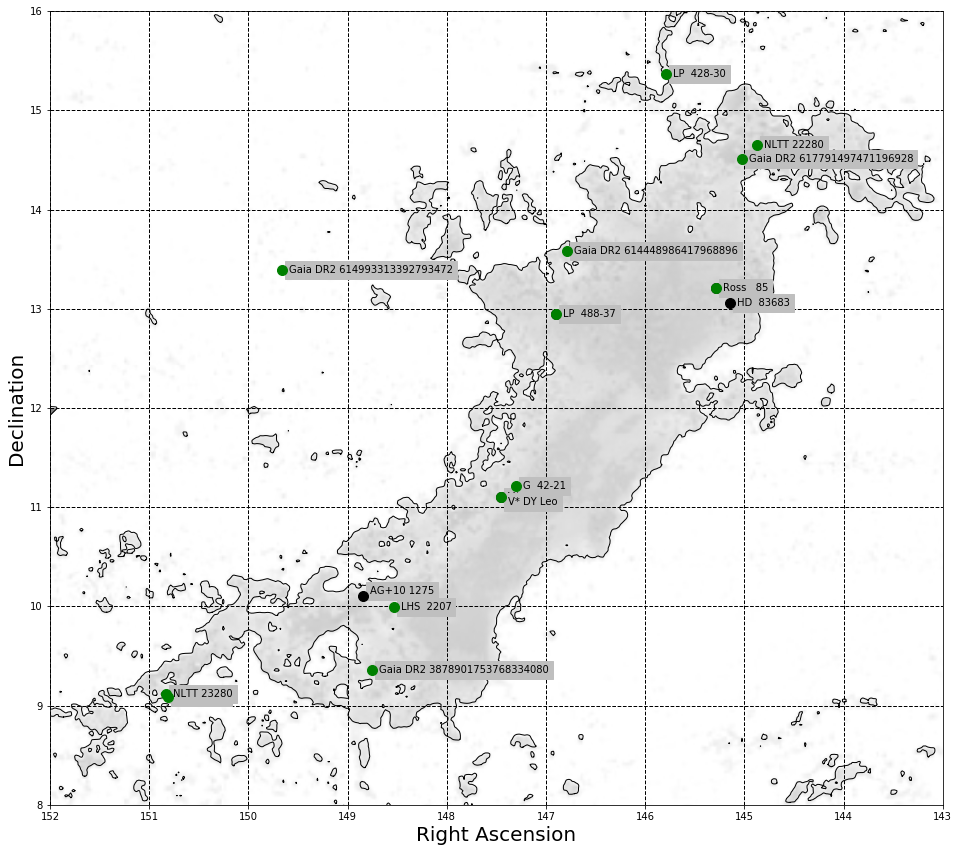

In [161]:
# 0-255 scale, higher == more lenient, lower == more conservative
contour_thres=220

fig=plt.figure(1,figsize=(16,16))
subplt=plt.subplot(111)
#plt.scatter(llcc['ra'],llcc['dec'],marker='o',color='k',s=0.1)

datafile = cbook.get_sample_data('/Users/codydirks/Desktop/llcc.png')
img = 255-np.dot(imread(datafile)[...,:3], [0.299, 0.587, 0.114])

imgy=len(img)
imgx=len(img[0])
plt.imshow(img, zorder=-1, extent=[157, 141, 2, 18],alpha=0.5,cmap=plt.get_cmap('gray'))

# Find and plot contours given above threshold parameter
contours = measure.find_contours(img, contour_thres)
for n, contour in enumerate(contours):
    subplt.plot(contour[:, 1]*(-16./float(imgy))+157, contour[:, 0]*(-16./float(imgx))+18, linewidth=1,color='k',alpha=1.0)

in_llcc_footprint=[]
for star in near:
    x=int(floor((star['ra']-157)*(-float(imgx)/16.)))
    y=int(floor((star['dec']-18)*(-float(imgy)/16.)))
    col='r'
    if img[y][x]<contour_thres and 143<star['ra']<152 and 8<star['dec']<16:
        in_llcc_footprint.append(star.index)
        result_table=Simbad.query_region(SkyCoord(ra=star['ra']*u.degree, dec=star['dec']*u.degree,frame='fk5',equinox='J2015.5'),radius='0h0m1s')
        if result_table !=None:
            name=result_table[0]['MAIN_ID']
        else:
            name='Gaia DR2 '+str(star['source_id'])
        col='g'

        va='center'
        if name=='V* DY Leo':
            va='top'
        subplt.plot(star['ra'],star['dec'],marker='o',color=col,markersize=10,zorder=5)
        subplt.text(star['ra']-0.07,star['dec'],name,rotation=rot,backgroundcolor='0.75',zorder=4,va=va,ha='left')
        #print '{:>30}'.format(name),round(star['ra'],4),round(star['dec'],4)

subplt.set_xlim(152,143)
subplt.set_ylim(8,16)
for ra in range(141,157):
    subplt.axvline(ra,0,1,linestyle='--',color='k',zorder=0,linewidth=1)
for dec in range(2,18):
    subplt.axhline(dec,0,1,linestyle='--',color='k',zorder=0,linewidth=1)
    
customSimbad=Simbad()
customSimbad.get_votable_fields()
customSimbad.add_votable_fields('ra(2d;A;FK5;J2015.5;2000)', 'dec(2d;D;FK5;2015.5;2000)')
customSimbad.remove_votable_fields('coordinates')

simbad_search=customSimbad.query_criteria('(ra>141 & ra < 157) & (dec>2 & dec <18) & plx > 20')
simbad_search['RA_2d_A_FK5_J2015_5_2000'].name='ra'
simbad_search['DEC_2d_D_FK5_2015_5_2000'].name='dec'
for row in simbad_search:
    x=int(floor((row['ra']-157)*(-float(imgx)/16.)))
    y=int(floor((row['dec']-18)*(-float(imgy)/16.)))
    col='k'
    if img[y][x]<contour_thres and 143<row['ra']<152 and 8<row['dec']<16:
        subplt.plot(row['ra'],row['dec'],marker='o',color='k',markersize=10,zorder=3)
        va='center'
        if row['MAIN_ID']=='AG+10 1275':
            va='bottom'
        subplt.text(row['ra']-0.07,row['dec'],row['MAIN_ID'],rotation=0,backgroundcolor='0.75',zorder=2,va=va,ha='left')
        

subplt.set_xlabel('Right Ascension',fontsize=20)
subplt.set_ylabel('Declination',fontsize=20)
#plt.savefig('/Users/codydirks/Desktop/LLCC_results.png')

In [148]:
print
print '{:>30}'.format('Name'),
print '{:>12}'.format('RA'),'{:>11}'.format('Dec'),
print '{:>10}'.format('Dist'),
print '{:>15}'.format('Parallax')
print ' '*10,'-'*75



llcc_stars=near[in_llcc_footprint]
for star in llcc_stars:
    result_table=Simbad.query_region(SkyCoord(ra=star['ra']*u.degree, dec=star['dec']*u.degree,
                                              frame='icrs',equinox='J2015.5'),radius='0h0m1s')
    if result_table !=None:
        name=result_table[0]['MAIN_ID']
    else:
        name='Gaia DR2 '+str(star['source_id']) 
    print '{:>30}'.format(name),
    print '{:>12.6f}'.format(round(star['ra'],6)),'{:>11.6f}'.format(round(star['dec'],6)),
    print '{:>10.2f}'.format(round(1000./star['parallax'],2)),
    print '{:>10.2f}'.format(round(star['parallax'],2)),'+-','{:>4.2f}'.format(round(star['parallax_error'],2))


                          Name           RA         Dec       Dist        Parallax
           ---------------------------------------------------------------------------
                     Ross   85   145.290249   13.208946      11.55      86.55 +- 0.04
                    NLTT 22280   144.874048   14.646804      19.44      51.45 +- 0.08
                    LP  488-37   146.894650   12.945177      21.23      47.10 +- 0.07
                     LHS  2207   148.535817    9.990338      26.21      38.16 +- 0.12
                    LP  428-30   145.785335   15.366794      32.90      30.40 +- 0.12
                      G  42-21   147.305367   11.209099      38.70      25.84 +- 0.10
                    LP  489-18   150.808913    9.086452      38.85      25.74 +- 0.06
  Gaia DR2 3878901753768334080   148.752154    9.357156      39.79      25.13 +- 0.09
   Gaia DR2 614448986417968896   146.782793   13.579807      42.58      23.48 +- 0.08
               LSPM J0939+1153   144.811629   11.890534

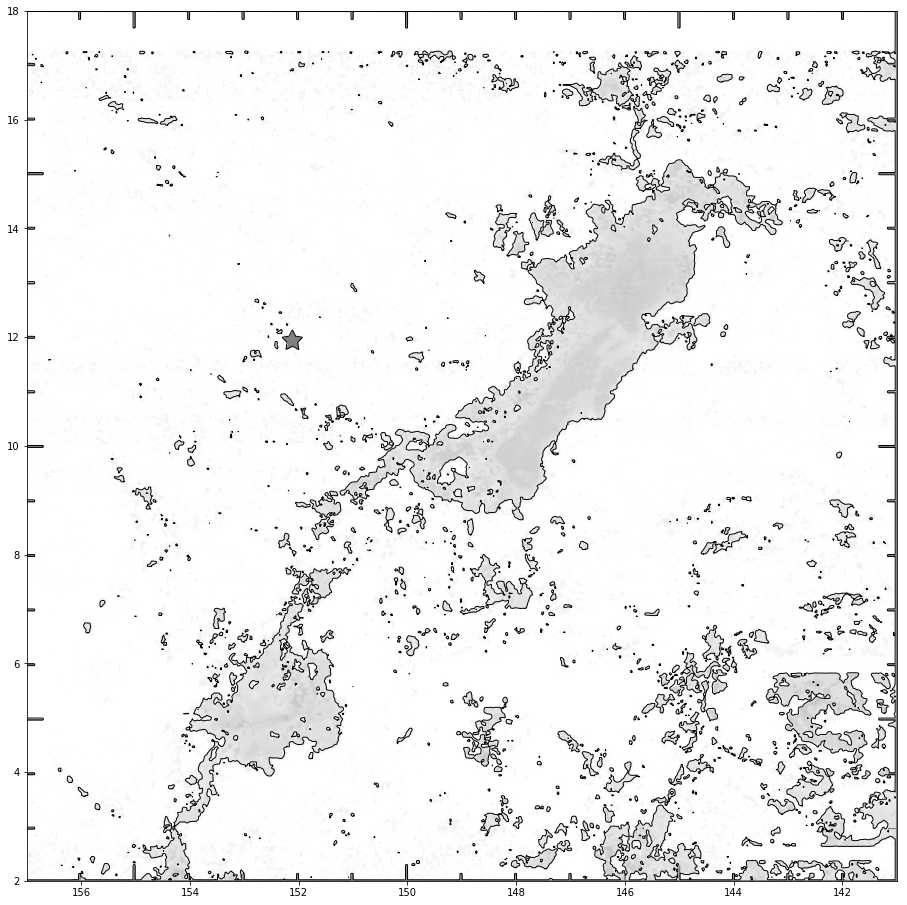

In [160]:
# 0-255 scale, higher == more lenient, lower == more conservative
contour_thres=220

fig=plt.figure(1,figsize=(16,16))
subplt=plt.subplot(111)
#plt.scatter(llcc['ra'],llcc['dec'],marker='o',color='k',s=0.1)

datafile = cbook.get_sample_data('/Users/codydirks/Desktop/llcc.png')
img = 255-np.dot(imread(datafile)[...,:3], [0.299, 0.587, 0.114])

imgy=len(img)
imgx=len(img[0])

plt.imshow(img, zorder=-1, extent=[157, 141, 2, 18],alpha=0.5,cmap=plt.get_cmap('gray'))

# Find and plot contours given above threshold parameter
contours = measure.find_contours(img, contour_thres)
for n, contour in enumerate(contours):
    subplt.plot(contour[:, 1]*(-16./float(imgx))+157, contour[:, 0]*(-16./float(imgy))+18, linewidth=1,color='k',alpha=1.0)

In [155]:
len(img[0])

1636